# Boey Jit Ming, Benjamin

In this notebook we are first normalizing and cleaning the data, then creating tables in an SQLite3 database and inserting the data, before using SQL statements to retrieve the appropriate data to create 3 informative visualizations. 

For reproducibility, this notebook should be inserted in a folder that contains another folder called "data", which should contain all 4 datasets from Kaggle - "Adult mortality.csv", "Maternal mortality.csv", "Number of deaths (thousands).csv", and "Probability of dying per 1000 live births.csv".

The three visualizations will attempt to answer the following driving questions:

* Which country had the highest average mortality rate across all available years?
* Which country had the highest neonatal death toll in 2012?
* Question 3



# Import required libraries


In [42]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import sqlite3


# Read in data and clean it

We now read in the datasets using pandas.

In [43]:
adult_mortality_raw = pd.read_csv('./data/Adult mortality.csv')
maternal_mortality_raw = pd.read_csv('./data/Maternal mortality.csv')
num_deaths_raw = pd.read_csv('./data/Number of deaths (thousands).csv')
probability_dying_raw = pd.read_csv('./data/Probability of dying per 1000 live births.csv')

Check the columns and their types, to see if any types should be converted.

In [44]:
print('Adult mortality types')
print(adult_mortality_raw.dtypes)
print('\nMaternal mortality types')
print(maternal_mortality_raw.dtypes)
print('\nNumber of deaths types')
print(num_deaths_raw.dtypes)
print('\nProbability of dying types')
print(probability_dying_raw.dtypes)

Adult mortality types
Unnamed: 0                                                                                   object
Unnamed: 1                                                                                   object
Adult mortality rate (probability of dying between 15 and 60 years per 1000 population)      object
Adult mortality rate (probability of dying between 15 and 60 years per 1000 population).1    object
Adult mortality rate (probability of dying between 15 and 60 years per 1000 population).2    object
dtype: object

Maternal mortality types
Country                                               object
Year                                                   int64
Maternal mortality ratio (per 100 000 live births)    object
Number of maternal deaths                             object
dtype: object

Number of deaths types
Unnamed: 0                                   object
Unnamed: 1                                   object
Number of under-five deaths (thousands)      object


We can see that many of the columns containing integer values are stored as strings instead, and some of the columns are unnamed. Looking at the data from the Kaggle website itself, it is now clear that some datasets have more specific headings in the second row instead.  

In order to insert the data into our SQlite3 tables, we need to clean the data; dropping the 1st row in the datasets where the first row are column headings, and also transforming all our integer columns to integers, since all of them are stored as strings instead. Please note that many of the values in the "Probability of dying" dataset are not whole numbers, so they are converted to float instead.

From Kaggle, we can see that there are no missing values, but if we did not have that information, we would have to decide whether to drop all rows with missing value, or try to impute the missing data.


# Data cleaning and transformations

At no point should we change the raw data; we will create new datasets and apply our cleaning/transformations to them.

## Adult Mortality


In [45]:
adult_mortality_raw.head()

,Unnamed: 0,Unnamed: 1,Adult mortality rate (probability of dying between 15 and 60 years per 1000 population),Adult mortality rate (probability of dying between 15 and 60 years per 1000 population).1,Adult mortality rate (probability of dying between 15 and 60 years per 1000 population).2
0,Country,Year,Both sexes,Male,Female
1,Afghanistan,2016,245,272,216
2,Afghanistan,2015,233,254,210
3,Afghanistan,2014,234,254,213
4,Afghanistan,2013,235,254,215


Dropping the first row as it contains headers, then changing the column names 

In [46]:
adult_mortality = adult_mortality_raw.drop(0)
adult_mortality.rename(columns={'Unnamed: 0':'country', 
                                'Unnamed: 1':'year', 
                                'Adult mortality rate (probability of dying between 15 and 60 years per 1000 population)':'adult_mortality_both', 
                                'Adult mortality rate (probability of dying between 15 and 60 years per 1000 population).1':'adult_mortality_male', 
                                'Adult mortality rate (probability of dying between 15 and 60 years per 1000 population).2':'adult_mortality_female'
                               }, inplace=True)

Changing the relevant columns to integer types, since they were stored as strings previously

In [47]:
adult_mortality = adult_mortality.astype({'year':'int', 
                                          'adult_mortality_both':'int', 
                                          'adult_mortality_male':'int', 
                                          'adult_mortality_female':'int'})

In [48]:
adult_mortality.head()

,country,year,adult_mortality_both,adult_mortality_male,adult_mortality_female
1,Afghanistan,2016,245,272,216
2,Afghanistan,2015,233,254,210
3,Afghanistan,2014,234,254,213
4,Afghanistan,2013,235,254,215
5,Afghanistan,2012,242,262,221



## Maternal Mortality


In [49]:
maternal_mortality_raw.head()

,Country,Year,Maternal mortality ratio (per 100 000 live births),Number of maternal deaths
0,Afghanistan,2017,638 [ 427 - 1 010 ],7 700 [ 5 100 - 12 000 ]
1,Afghanistan,2016,673 [ 457 - 1 040 ],8 100 [ 5 500 - 12 000 ]
2,Afghanistan,2015,701 [ 501 - 1 020 ],8 400 [ 6 000 - 12 000 ]
3,Afghanistan,2014,786 [ 592 - 1 080 ],9 300 [ 7 000 - 13 000 ]
4,Afghanistan,2013,810 [ 617 - 1 080 ],9 600 [ 7 300 - 13 000 ]


There are no headers in the rows themselves, so no rows need to be dropped. However, the columns need to be renamed. For all datasets, it is important to remember the ratios, whether the data is per 1000 or per 100,000; however, I am not keeping track of this in the columns themselves.

In [50]:
maternal_mortality = maternal_mortality_raw.rename(columns={'Country':'country', 
                                                            'Year':'year', 
                                                            'Maternal mortality ratio (per 100 000 live births)':'maternal_mortality_ratio', 
                                                            'Number of maternal deaths':'maternal_deaths'
                                                           })

Now we change the relevant columns from strings to integers.

In [51]:
maternal_mortality = maternal_mortality.astype({'year':'int'})

I confess I am not quite sure why the mortality ratios and number of maternal deaths are presented as "x [ y - z ]", and there exists no metadata on the Kaggle page that explains this, but I shall leave that aside for now.

In [52]:
maternal_mortality.head()

,country,year,maternal_mortality_ratio,maternal_deaths
0,Afghanistan,2017,638 [ 427 - 1 010 ],7 700 [ 5 100 - 12 000 ]
1,Afghanistan,2016,673 [ 457 - 1 040 ],8 100 [ 5 500 - 12 000 ]
2,Afghanistan,2015,701 [ 501 - 1 020 ],8 400 [ 6 000 - 12 000 ]
3,Afghanistan,2014,786 [ 592 - 1 080 ],9 300 [ 7 000 - 13 000 ]
4,Afghanistan,2013,810 [ 617 - 1 080 ],9 600 [ 7 300 - 13 000 ]



## Number of deaths (thousands)


In [53]:
num_deaths_raw.head()

,Unnamed: 0,Unnamed: 1,Number of under-five deaths (thousands),Number of under-five deaths (thousands).1,Number of under-five deaths (thousands).2,Number of infant deaths (thousands),Number of infant deaths (thousands).1,Number of infant deaths (thousands).2,Number of neonatal deaths (thousands)
0,Country,Year,Both sexes,Male,Female,Both sexes,Male,Female,Both sexes
1,Afghanistan,2018,74278,40312,33966,57182,31394,25788,44725
2,Afghanistan,2017,76877,41631,35246,58846,32244,26602,45771
3,Afghanistan,2016,79770,43134,36636,60673,33222,27451,46963
4,Afghanistan,2015,82918,44733,38185,62652,34257,28395,48237


The same thing has to be done here as with the Adult Mortality data - the first row needs to be dropped, the columns all need renaming, and all the columns but 'country' have to be changed to integers. I will keep in mind that the numbers are in thousands.

Dropping the first row and renaming columns

In [54]:
num_deaths = num_deaths_raw.drop(0)
num_deaths.rename(columns={'Unnamed: 0':'country', 
                           'Unnamed: 1':'year', 
                           'Number of under-five deaths (thousands)':'under_five_both', 
                           'Number of under-five deaths (thousands).1':'under_five_male', 
                           'Number of under-five deaths (thousands).2':'under_five_female', 
                           'Number of infant deaths (thousands)':'infant_both', 
                           'Number of infant deaths (thousands).1':'infant_male', 
                           'Number of infant deaths (thousands).2':'infant_female', 
                           'Number of neonatal deaths (thousands)':'neonatal'
                          }, inplace=True)

Changing columns to integers

In [55]:
num_deaths = num_deaths.astype({'year':'int', 
                                'under_five_both':'int', 
                                'under_five_male':'int', 
                                'under_five_female':'int', 
                                'infant_both':'int', 
                                'infant_male':'int', 
                                'infant_female':'int', 
                                'neonatal':'int'
                               })

In [56]:
num_deaths.head()

,country,year,under_five_both,under_five_male,under_five_female,infant_both,infant_male,infant_female,neonatal
1,Afghanistan,2018,74278,40312,33966,57182,31394,25788,44725
2,Afghanistan,2017,76877,41631,35246,58846,32244,26602,45771
3,Afghanistan,2016,79770,43134,36636,60673,33222,27451,46963
4,Afghanistan,2015,82918,44733,38185,62652,34257,28395,48237
5,Afghanistan,2014,86378,46509,39869,64808,35410,29398,49715


## Probability of dying per 1000 live births

In [57]:
probability_dying_raw.head()

,Unnamed: 0,Unnamed: 1,Infant mortality rate (probability of dying between birth and age 1 per 1000 live births),Infant mortality rate (probability of dying between birth and age 1 per 1000 live births).1,Infant mortality rate (probability of dying between birth and age 1 per 1000 live births).2,Neonatal mortality rate (per 1000 live births),Under-five mortality rate (probability of dying by age 5 per 1000 live births),Under-five mortality rate (probability of dying by age 5 per 1000 live births).1,Under-five mortality rate (probability of dying by age 5 per 1000 live births).2
0,Country,Year,Both sexes,Male,Female,Both sexes,Both sexes,Male,Female
1,Afghanistan,2018,47.9,51.1,44.5,37.1,62.3,65.7,58.7
2,Afghanistan,2017,49.5,52.7,46,38.1,64.7,68.1,61.1
3,Afghanistan,2016,51.2,54.5,47.7,39.3,67.5,70.9,63.7
4,Afghanistan,2015,53.1,56.5,49.6,40.5,70.4,73.8,66.7


The same thing will be done here - dropping the first row, changing column names, then changing to a numeric type.

In [58]:
probability_dying = probability_dying_raw.drop(0)
probability_dying.rename(columns={'Unnamed: 0':'country', 
                                  'Unnamed: 1':'year', 
                                  'Infant mortality rate (probability of dying between birth and age 1 per 1000 live births)':'infant_both', 
                                  'Infant mortality rate (probability of dying between birth and age 1 per 1000 live births).1':'infant_male', 
                                  'Infant mortality rate (probability of dying between birth and age 1 per 1000 live births).2':'infant_female', 
                                  'Neonatal mortality rate (per 1000 live births)':'neonatal', 
                                  'Under-five mortality rate (probability of dying by age 5 per 1000 live births)':'under_five_both', 
                                  'Under-five mortality rate (probability of dying by age 5 per 1000 live births).1':'under_five_male', 
                                  'Under-five mortality rate (probability of dying by age 5 per 1000 live births).2':'under_five_female'
                                 }, inplace=True)


Changing the relevant columns to numeric, bearing in mind that this dataset contains a lot of decimal numbers, so we use float instead of int types.


In [59]:
probability_dying = probability_dying.astype({'year':'int', 
                                              'infant_both':'float', 
                                              'infant_male':'float', 
                                              'infant_female':'float', 
                                              'infant_female':'float', 
                                              'neonatal':'float', 
                                              'under_five_both':'float', 
                                              'under_five_male':'float', 
                                              'under_five_female':'float'
                                             })

In [60]:
probability_dying.head()

,country,year,infant_both,infant_male,infant_female,neonatal,under_five_both,under_five_male,under_five_female
1,Afghanistan,2018,47.9,51.1,44.5,37.1,62.3,65.7,58.7
2,Afghanistan,2017,49.5,52.7,46.0,38.1,64.7,68.1,61.1
3,Afghanistan,2016,51.2,54.5,47.7,39.3,67.5,70.9,63.7
4,Afghanistan,2015,53.1,56.5,49.6,40.5,70.4,73.8,66.7
5,Afghanistan,2014,55.1,58.6,51.5,41.9,73.6,77.0,69.9


Now that we have cleaned our data and done the necessary transformation, we can proceed to create tables in an SQL database, insert the data into the tables, and then query the database and perform our visualizations. 

# SQLite3 Database

We start by creating the database.


In [61]:
conn = sqlite3.connect("mortality.db")
print(conn.total_changes)

0


Now we have verified the connection and database, we can create our tables.

In [62]:
cursor = conn.cursor()

"adult" table

In [63]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS adult (
country VARCHAR(20), 
year INTEGER, 
adult_mortality_both INTEGER, 
adult_mortality_male INTEGER, 
adult_mortality_female INTEGER
)
""")

"maternal" table

In [64]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS maternal (
country VARCHAR(20), 
year INTEGER, 
maternal_mortality_ratio VARCHAR(20), 
maternal_deaths VARCHAR(20)
)
""")

"num_deaths" table

In [65]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS num_deaths (
country VARCHAR(20), 
year INTEGER, 
under_five_both INTEGER, 
under_five_male INTEGER, 
under_five_female INTEGER, 
infant_both INTEGER, 
infant_male INTEGER, 
infant_female INTEGER, 
neonatal INTEGER
)
""")

"probability_dying" table

In [66]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS probability_dying (
country VARCHAR(20), 
year INTEGER, 
infant_both FLOAT, 
infant_male FLOAT, 
infant_female FLOAT, 
neonatal FLOAT, 
under_five_both FLOAT, 
under_five_male FLOAT, 
under_five_female FLOAT
)
""")

## Inserting the data into the SQLite3 tables

In [67]:
adult_mortality.to_sql('adult', conn, if_exists='replace', index=False)

In [68]:
maternal_mortality.to_sql('maternal', conn, if_exists='replace', index=False)

In [69]:
num_deaths.to_sql('num_deaths', conn, if_exists='replace', index=False)

In [70]:
probability_dying.to_sql('probability_dying', conn, if_exists='replace', index=False)

Now that we have our tables, we can start querying them with SQL statements, and return the results to new dataframes for visualization in matplotlib.pylot.

Let us start with a simple example to test whether our database is working.

We will try to find the data for adult mortality rates(both sexes only), for the country of Australia, between 2002 and 2009.

Testing to see if SQL query works:

In [71]:
test_aus = cursor.execute("""
SELECT adult_mortality_both FROM adult
WHERE country = 'Australia'
AND
YEAR BETWEEN 2002 AND 2009
""").fetchall()
print(test_aus)

[(65,), (64,), (65,), (65,), (68,), (67,), (69,), (72,)]


Turning the result into a pandas dataframe

In [72]:
test_aus2 = pd.DataFrame(test_aus, columns=['adult_mortality_both'])
print(test_aus2)


   adult_mortality_both
0                    65
1                    64
2                    65
3                    65
4                    68
5                    67
6                    69
7                    72


# Driving Question 1: Which country had the highest average adult mortality rate across all available years?

To answer this question, I will average the number of adult deaths by country regardless of year. Then, I will export the results to a pandas dataframe and visualize it with a bar chart in matplotlib.pyplot.

In [73]:
dq1 = cursor.execute("""
SELECT country, AVG(adult_mortality_both)
FROM adult
GROUP BY country
ORDER BY AVG(adult_mortality_both) DESC
""").fetchall()

In [74]:
dq1_df = pd.DataFrame(dq1, columns=['country', 'adult_mortality'])
print(dq1_df)

                      country  adult_mortality
0                    Zimbabwe       549.352941
1                     Lesotho       536.235294
2                    Eswatini       529.000000
3    Central African Republic       491.647059
4                Sierra Leone       452.117647
..                        ...              ...
178                     Italy        62.294118
179                    Sweden        62.176471
180                     Malta        61.470588
181               Switzerland        61.294118
182                   Iceland        59.117647

[183 rows x 2 columns]


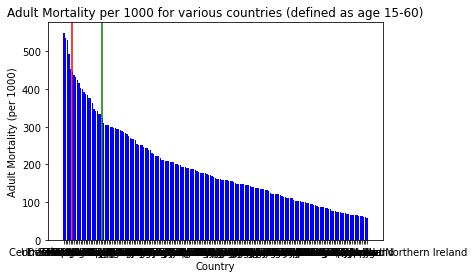

In [75]:
plt.bar(dq1_df['country'], dq1_df['adult_mortality'], color='b')
plt.axvline(x=5, color='r')
plt.axvline(x=23, color = 'g')
plt.xlabel("Country")
plt.ylabel("Adult Mortality (per 1000)")
plt.title("Adult Mortality per 1000 for various countries (defined as age 15-60)")
plt.show()

From the visualization we can see that there is a steep drop after the first 4 or so countries, and another drop after the first 23. The country with the highest adult mortality rate from 2000-2017 is Zimbabwe, with 549.35 adult deaths per 1000 each year on average.

# Driving Question 2: Which country has the highest discrepancy between male and female infant deaths?

To answer this question, I will use SQL to give us the answer, but I will also plot the male and female infant deaths on the same bar chart to visualize the difference for each country.

In [76]:
dq2 = cursor.execute("""
SELECT country, AVG(infant_male)-AVG(infant_female)
FROM num_deaths
GROUP BY country
ORDER BY ABS(AVG(infant_male)-AVG(infant_female)) DESC
""").fetchall()

In [77]:
dq2_df = pd.DataFrame(dq2, columns=['country','m_f'])
print(dq2_df)

                              country           m_f
0                             Nigeria  66169.000000
1                            Pakistan  47912.000000
2                               India  34635.166667
3    Democratic Republic of the Congo  23833.333333
4                            Ethiopia  22601.500000
..                                ...           ...
189                        San Marino     -0.666667
190                             Palau      0.500000
191                            Tuvalu      0.333333
192                      Cook Islands      0.000000
193                           Andorra      0.000000

[194 rows x 2 columns]


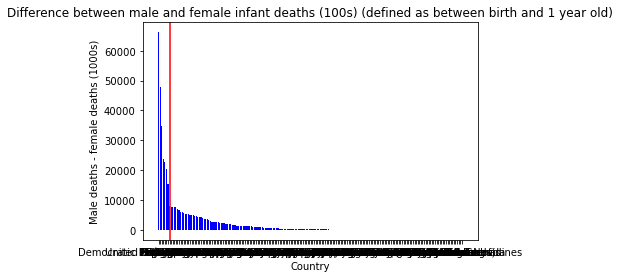

In [78]:
plt.bar(dq2_df['country'], dq2_df['m_f'], color = 'b')
plt.xlabel('Country')
plt.axvline(x=7, color='r')
plt.ylabel('Male deaths - female deaths (1000s)')
plt.title('Difference between male and female infant deaths (100s) (defined as between birth and 1 year old)')
plt.show()

As can be seen from the visualization, the first 7 countries are the highest offenders, with the difference between male and female infant deaths being much closer to the same for other countries. Purely out of curiosity, let us see if there are any countries with more male infants dying than female ones.

Modify the SQL statement to include a HAVING clause where the (average male deaths - average female deaths) is less than 0.

In [79]:
dq2_mod = cursor.execute("""
SELECT country, AVG(infant_male)-AVG(infant_female)
FROM num_deaths
GROUP BY country
HAVING AVG(infant_male)-AVG(infant_female)<0
ORDER BY ABS(AVG(infant_male)-AVG(infant_female)) DESC
""").fetchall()

Convert the SQL table to a pandas dataframe

In [80]:
dq2mod_df = pd.DataFrame(dq2_mod, columns=['country','m_f'])
print(dq2mod_df)

      country       m_f
0       Tonga -4.000000
1        Niue -1.000000
2  San Marino -0.666667


Plot the results on a graph

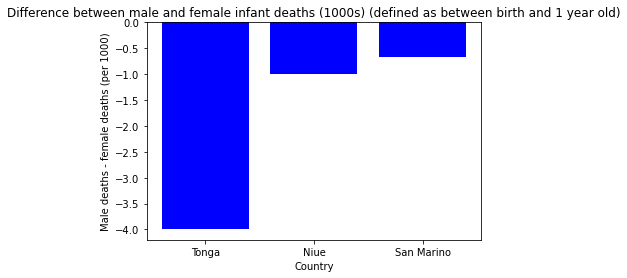

In [81]:
plt.bar(dq2mod_df['country'], dq2mod_df['m_f'], color = 'b')
plt.xlabel('Country')
plt.ylabel('Male deaths - female deaths (per 1000)')
plt.title('Difference between male and female infant deaths (1000s) (defined as between birth and 1 year old)')
plt.show()

With only 3 countries having more male infant deaths than female ones, one might be inclined to believe that male infants have higher survivability - of course, this may very well not be the case, and the results might be affected by external factors.

# Driving Question 3: Which country had the highest birth rate from 2000-2017? 

To answer this question, 

In [82]:
#conn.close()